<a href="https://colab.research.google.com/github/saw9090/-/blob/main/NLFFR_%EB%B9%84%EA%B5%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Nonlinear function-on-function regression by RKHS

In [ ]:
from sklearn.metrics.pairwise import rbf_kernel
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
from skfda.misc import inner_product
from skfda.representation import FDataGrid

## useful functions

In [ ]:
# kernel 함수 정의
def GRB(x,y,gamma):
  return np.exp(-gamma*(x-y)**2)

In [ ]:
def RKHS_kernel(x,y,grid,gamma_X) :
  return np.exp(-gamma_X*inner_product(x-y,x-y))

In [ ]:
def RKHS_kernel_matrix(X,grid, gamma_X=1):
    n = X.shape[1]
    kernel_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i, n):
            kernel_matrix[i, j] = RKHS_kernel(X[:, i], X[:, j],grid, gamma_X=gamma_X)
    kernel_matrix += kernel_matrix.T - np.diag(np.diag(kernel_matrix))
    return kernel_matrix

In [ ]:
def d(x,grid,gamma_X) :
  d_x = np.zeros(N)
  for i in range(N) :
    d_x[i] = RKHS_kernel(X[:,i],x,grid,gamma_X) - np.mean(K_X[i,:])
  return d_x

## model1_dense design

In [ ]:
# X generating 함수 정의
def data_generate(gamma,n=100,kernel = GRB) :
  X = np.zeros((51,n))
  for i in range(n) :
    t = np.random.uniform(size = 5)
    a = np.random.normal(size = 5)
    grid = np.linspace(0, 1, 51)
    matrix = np.zeros((51,5))
    for j in range(51) :
      for k in range(5) :
        matrix[j,k] = kernel(grid[j],t[k],gamma)
    X[:,i] = matrix @ a
  return X

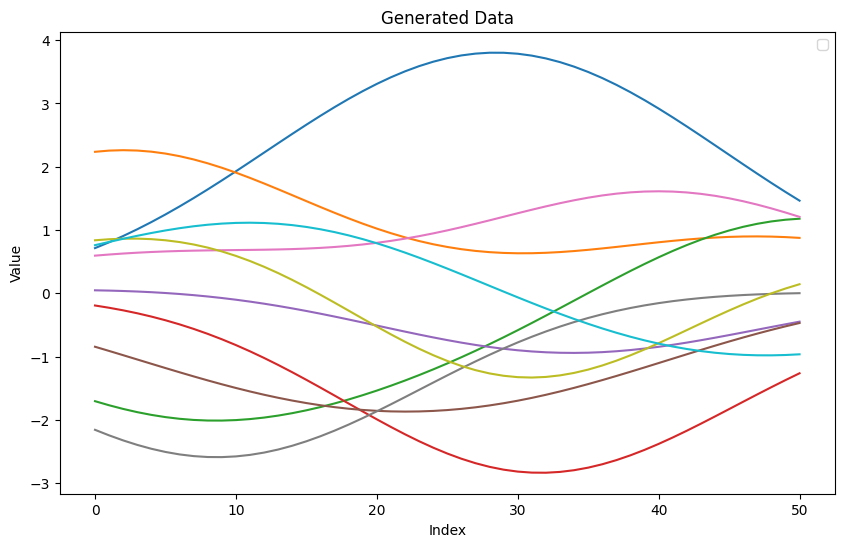

In [ ]:
# X 생성 및 개형
np.random.seed(0)
N=100
X = data_generate(gamma=7, n=N)

plt.figure(figsize=(10, 6))
for i in range(10):
    plt.plot(X[:, i])

plt.title('Generated Data')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# rho 정의
def rho(t) :
  rho = 0
  np.random.seed(0)
  a = np.random.normal(size = 5)
  for i in range(5):
    rho += np.sqrt(2) * a[i] * np.sin((i+1/2)* np.pi * t)
  return rho

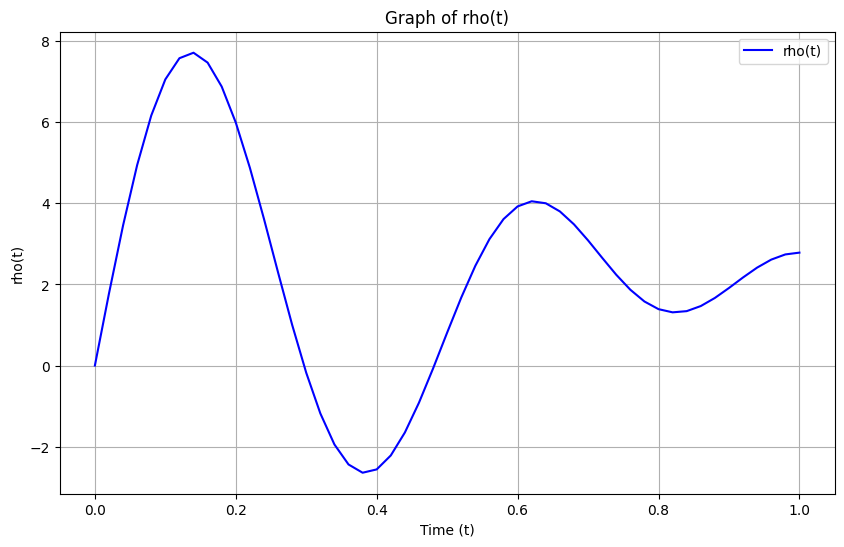

In [ ]:
# rho 개형
t = np.linspace(0, 1, 51)
rho_values = [rho(ti) for ti in t]

plt.figure(figsize=(10, 6))
plt.plot(t, rho_values, label='rho(t)', color='b')
plt.xlabel('Time (t)')
plt.ylabel('rho(t)')
plt.title('Graph of rho(t)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# brownian motion 정의
def brownian_motion(T, N, seed = None):
    dt = T / float(N)
    t = np.linspace(0, T, N+1)
    W = np.zeros(N+1)
    np.random.seed(seed)
    for i in range(1, N+1):
        dW = np.sqrt(dt) * np.random.normal(0, 1)
        W[i] = W[i-1] + dW
    return t, W

In [ ]:
# 모델 정의
def b1(t,kernel = GRB,gamma = 7) :
  return kernel(t,0.6,gamma=gamma)
def b2(t,kernel = GRB,gamma = 7) :
  return kernel(t,0.9,gamma=gamma)
def b3(t,kernel = GRB,gamma = 7) :
  return kernel(t,0.1,gamma=gamma)

def model1(X,gamma = 7, sigma = 2,seed = 0):
  fd_X = FDataGrid(X.T,grid)
  grid_X = np.linspace(0, 1, 51)
  grid_y = np.linspace(0, 1, 51)
  b1_t = FDataGrid(b1(grid_X),grid)
  b2_t = FDataGrid(b2(grid_X),grid)
  rho_t = rho(grid_y)
  _,brownian_t =  brownian_motion(1,50,seed = seed)
  inner_1 = inner_product(fd_X,b1_t)
  inner_2 = inner_product(fd_X,b2_t)
  y= (1/(np.exp(inner_1) + 1) + inner_2**2) * rho_t + sigma * brownian_t
  return y

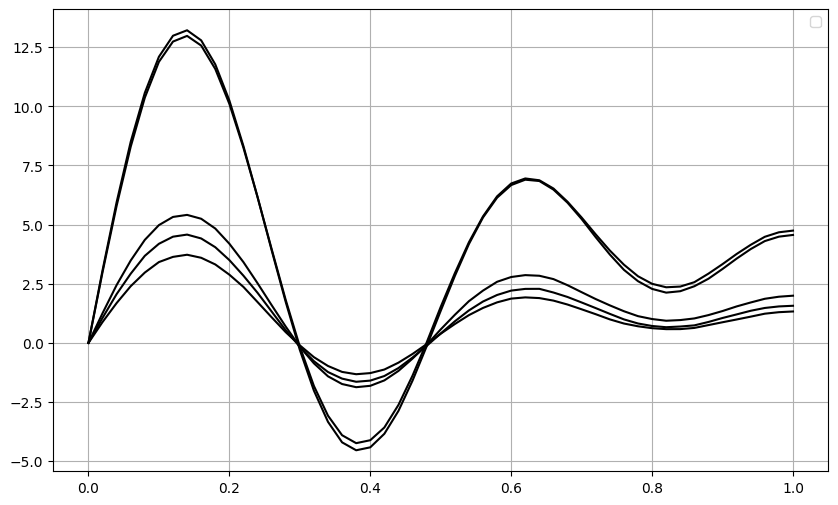

In [ ]:
# Y 생성 및 개형
grid = np.linspace(0, 1, 51)
grid_x = np.linspace(0, 1, 51)
grid_y = np.linspace(0, 1, 51)
y = np.zeros((len(grid_y), X.shape[1]))
for n in range(X.shape[1]):
  y[:,n] = model1(X[:,n],sigma = 0.1,seed=n)
plt.figure(figsize=(10, 6))
for n in range(5):
  plt.plot(grid_y, y[:,n], color='black')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
X_test = data_generate(gamma=7, n=10)
y_test = np.zeros((len(grid_y), X_test.shape[1]))
for n in range(X_test.shape[1]):
  y_test[:,n] = model1(X_test[:,n],sigma=0.1,seed = n + N)

In [ ]:
y_test.shape

(51, 10)

In [ ]:
Q = np.eye(N) - np.ones((N,N))/N

In [ ]:
from sklearn.model_selection import ParameterGrid
import numpy as np

gamma_values = [1e-1,1e-2,1e-3,1e-4,1e-5]
epsilon_values = [1e-1,1e-2,1e-3,1e-4,1e-5]


grid = np.linspace(0, 1, 51)
best_gcv = float('inf')
best_params = None

# Grid search
y_mean = np.mean(y,axis=1)
fd_y = FDataGrid(y.T,grid)
for gamma_X in gamma_values:
  K_X = RKHS_kernel_matrix(X,grid,gamma_X=gamma_X)
  G_X = Q @ K_X @ Q
  d_x = np.zeros((N,N))
  for j in range(N):
    d_x[:,j] = d(X[:,j],grid,gamma_X)
  for epsilon_X in epsilon_values:
    GCV = 0
    moore_G_X = np.linalg.pinv(G_X + epsilon_X *np.eye(N))
    moore_K_X = np.linalg.pinv(K_X + epsilon_X *np.eye(N))
    for i in range(N) :
      y_pred = y @ G_X @ moore_G_X @ Q @ moore_K_X @ d_x[:,i] + y_mean
      fd_y_pred = FDataGrid(y_pred,grid)
      GCV += inner_product(fd_y_pred-fd_y[i],fd_y_pred-fd_y[i])/(1-np.trace(Q @ G_X @ moore_G_X + np.ones((N,N))/N)/N)**2
    GCV /= N
    if GCV < best_gcv:
      best_gcv = GCV
      best_epsilon = epsilon_X
      best_gamma = gamma_X


print(f"Best GCV: {best_gcv}")
print(f"Best epsilon: {best_epsilon}")
print(f"Best gamma: {best_gamma}")

Best GCV: [0.00713295]
Best epsilon: 1e-05
Best gamma: 0.0001


In [ ]:
epsilon_X = best_epsilon
gamma_X = best_gamma

In [ ]:
K_X = RKHS_kernel_matrix(X,grid,gamma_X=gamma_X)
G_X = Q @ K_X @ Q
moore_G_X = np.linalg.pinv(G_X + epsilon_X *np.eye(N))
moore_K_X = np.linalg.pinv(K_X + epsilon_X *np.eye(N))

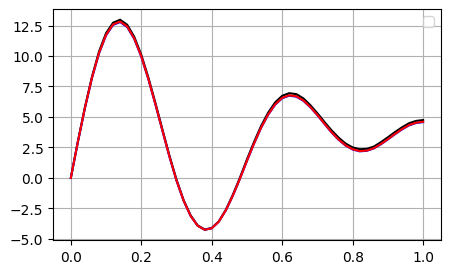

In [ ]:
# train(X1,Y1)
y_pred1 = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X[:,0],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(moore_G_X @ G_X @ Q[:,0] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(5,3))
plt.plot(grid_y, y[:,0], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

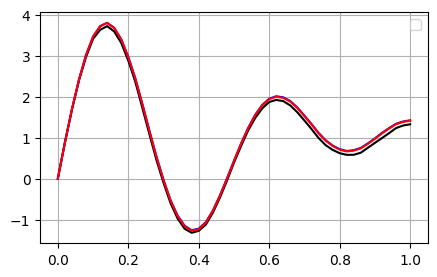

In [ ]:
# train(X2,Y2)
y_pred1 = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X[:,1],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(moore_G_X @ G_X @ Q[:,1] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(5,3))
plt.plot(grid_y, y[:,1], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

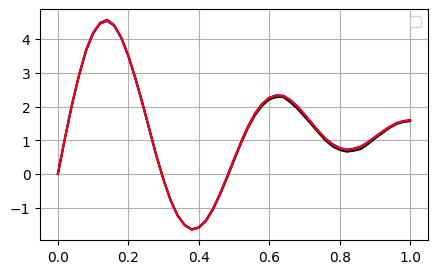

In [ ]:
# train(X3,Y3)
y_pred1 = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X[:,2],grid,gamma_X) + np.mean(y,axis=1)
y_pred2 = (y@(moore_G_X @ G_X @ Q[:,2] +1/N).reshape(-1,1)).flatten()
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(5, 3))
plt.plot(grid_y, y[:,2], color='black')
plt.plot(grid_y, y_pred1, color='blue')
plt.plot(grid_y, y_pred2, color='red')
plt.legend()
plt.grid(True)
plt.show()

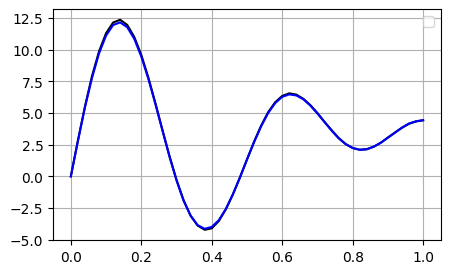

In [ ]:
# test(X1,Y1)
y_pred = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X_test[:,0],grid,gamma_X) + np.mean(y,axis=1)
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=(5,3))
plt.plot(grid_y, y_test[:,0], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

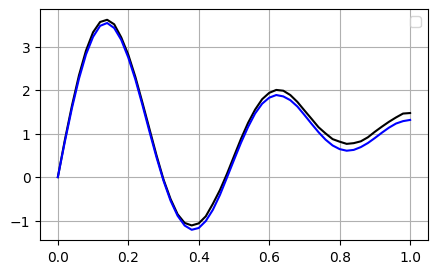

In [ ]:
# test(X2,Y2)
y_pred = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X_test[:,1],grid,gamma_X) + y_mean
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=((5, 3)))
plt.plot(grid_y, y_test[:,1], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

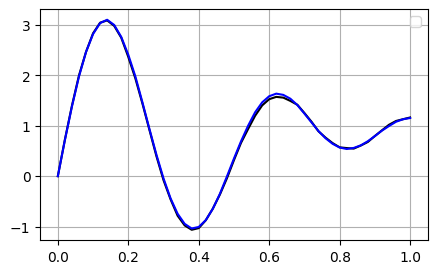

In [ ]:
# test(X3,Y3)
y_pred = y @ (G_X @ moore_G_X @ Q @ moore_K_X) @ d(X_test[:,2],grid,gamma_X) + y_mean
grid_y = np.linspace(0, 1, 51)

plt.figure(figsize=((5, 3)))
plt.plot(grid_y, y_test[:,2], color='black')
plt.plot(grid_y, y_pred, color='blue')
plt.legend()
plt.grid(True)
plt.show()

# Nonlinear functional regression: a functional RKHS approach


In [ ]:
def kernel_c(x,y,c=0.01):
  return np.exp(-c*(x-y)**2)

In [ ]:
grid = np.linspace(0, 1, 51)
N = X.shape[1]
p = len(grid)
C = np.zeros((N*p, N*p))
for l in range(p):
  C_sub = np.zeros((N, N))
  for i in range(N):
    for j in range(i, N):
      C_sub[i,j] = kernel_c(X[l,i],X[l,j])
  C_sub += C_sub.T -np.diag(np.diag(C_sub))
  C[l*N:(l+1)*N, l*N:(l+1)*N] = C_sub

In [ ]:
Y = np.zeros((N*p, p))
for l in range(p):
  for i in range(N) :
    Y[l*N:(l+1)*N,l] = y[l,:]

In [ ]:
lambda_ = 0.001
beta = np.linalg.pinv(C + lambda_ *np.eye(N*p)) @ Y

In [ ]:
beta_hat = np.zeros((N, p))
for l in range(p):
  for i in range(N) :
    beta_hat[:,l] = beta[l*N:(l+1)*N,l]

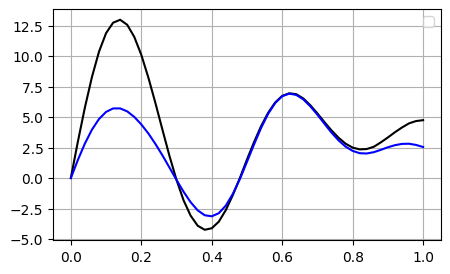

In [ ]:
y_hat = np.zeros(p)
C_X = np.zeros(N)
for l in range(p):
  for i in range(N) :
    C_X[i] = kernel_c(X[:,i][l],X[:,0][l])
  y_hat[l] = C_X @ beta_hat[:,l]

plt.figure(figsize=((5, 3)))
plt.plot(grid, y[:,0], color='black')
plt.plot(grid, y_hat, color='blue')
plt.legend()
plt.grid(True)
plt.show()

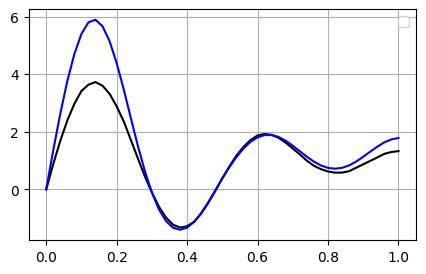

In [ ]:
y_hat = np.zeros(p)
C_X = np.zeros(N)
for l in range(p):
  for i in range(N) :
    C_X[i] = kernel_c(X[:,i][l],X[:,1][l])
  y_hat[l] = C_X @ beta_hat[:,l]

plt.figure(figsize=((5, 3)))
plt.plot(grid, y[:,1], color='black')
plt.plot(grid, y_hat, color='blue')
plt.legend()
plt.grid(True)
plt.show()

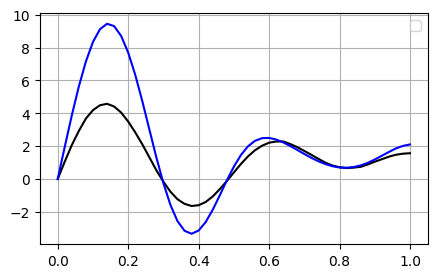

In [ ]:
y_hat = np.zeros(p)
C_X = np.zeros(N)
for l in range(p):
  for i in range(N) :
    C_X[i] = kernel_c(X[:,i][l],X[:,2][l])
  y_hat[l] = C_X @ beta_hat[:,l]

plt.figure(figsize=((5, 3)))
plt.plot(grid, y[:,2], color='black')
plt.plot(grid, y_hat, color='blue')
plt.legend()
plt.grid(True)
plt.show()

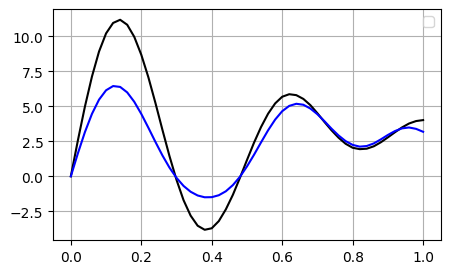

In [ ]:
y_hat = np.zeros(p)
C_X = np.zeros(N)
for l in range(p):
  for i in range(N) :
    C_X[i] = kernel_c(X[:,i][l],X_test[:,4][l])
  y_hat[l] = C_X @ beta_hat[:,l]

plt.figure(figsize=((5, 3)))
plt.plot(grid_y, y_test[:,4], color='black')
plt.plot(grid_y, y_hat, color='blue')
plt.legend()
plt.grid(True)
plt.show()